In [2]:
%matplotlib inline
import scipy.optimize
import matplotlib.pyplot as plt

Attribution: These examples are taken from the [Scipy Tutorial](https://docs.scipy.org/doc/scipy-0.18.1/reference/tutorial/optimize.html)

The `scipy.optimize` package provides several commonly used optimization algorithms. A detailed listing can be found by:

In [3]:
help(scipy.optimize)

Help on package scipy.optimize in scipy:

NAME
    scipy.optimize

FILE
    /Volumes/nobackup/Research/anaconda2/envs/nextai/lib/python2.7/site-packages/scipy/optimize/__init__.py

DESCRIPTION
    Optimization and root finding (:mod:`scipy.optimize`)
    
    .. currentmodule:: scipy.optimize
    
    Optimization
    
    Local Optimization
    ------------------
    
    .. autosummary::
       :toctree: generated/
    
       minimize - Unified interface for minimizers of multivariate functions
       minimize_scalar - Unified interface for minimizers of univariate functions
       OptimizeResult - The optimization result returned by some optimizers
       OptimizeWarning - The optimization encountered problems
    
    The `minimize` function supports the following methods:
    
    .. toctree::
    
       optimize.minimize-neldermead
       optimize.minimize-powell
       optimize.minimize-cg
       optimize.minimize-bfgs
       optimize.minimize-newtoncg
       optimize.minimize

For Machine Learning, we are mainly interested in unconstrained minimization of multivariate scalar functions (typically where gradient information is available). In addition to several algorithms for unconstrained minimization of multivariate scalar functions (e.g. BFGS, Nelder-Mead simplex, Newton Conjugate Gradient, etc.) the module also contains:
- Global (brute-force) optimization routines
- Least-squares minimization (which we saw before in the Linear Algebra Notebook)
- Scalar univariate function minimizers and root finders; and
- Multivariate equation system solvers using a variety of algorithms

# Unconstrained minimization of multivariate scalar functions (`minimize`)

The `minimize` function provides a common interface to unconstrained and constrained minimization algorithms for multivariate scalar functions. To demonstrate the minimization function, let's consider the problem of minimizing the Rosenbrock function of $N$ variables:
$$ f\left(\mathbf{x}\right)=\sum_{i=1}^{N-1}100\left(x_{i}-x_{i-1}^{2}\right)^{2}+\left(1-x_{i-1}\right)^{2}.$$

The minimum value of this function is 0 which is achieved when $x_i=1$.

Note that the Rosenbrock function and its derivatives are included in `scipy.optimize`. The implementations in the following provide examples of how to define an objective function as well as its Jacobian and Hessian functions.

## Nelder-Mead Simplex algorithm (`method='Nelder-Mead'`)

In the example below, the `minimize` routine is used with the *Nelder-Mead* simplex algorithm (selected through the `method` parameter):

In [4]:
import numpy as np
from scipy.optimize import minimize

In [5]:
def rosen(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

In [6]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = minimize(rosen, x0, method='nelder-mead',
               options={'xtol': 1e-8, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 339
         Function evaluations: 571
[ 1.  1.  1.  1.  1.]


The simplex method is a simple way to minimize a fairly well-behaved function. It only requires function evaluations and is a good choice for simple minimization problems. However, because it does not use any gradient evaluations, it may take longer to find the minimum.

## Broyden-Fletcher-Golfarb-Shanno algorithm (`method='BFGS'`)

In order to converge more quickly to the solution, this routine uses the gradient of the objective function. If the gradient is not given by the user, then it is estimated using first-differences. The Broyden-Fletcher-Golfarb-Shanno (BFGS) method typically requires fewer calls than the simplex algorithm even when the gradient must be estimated.

To demonstrate this algorithm, the Rosenbrock function is used again. The gradient of the Rosenbrock function is the vector:

$$ \begin{eqnarray*} \frac{\partial f}{\partial x_{j}} & = & \sum_{i=1}^{N}200\left(x_{i}-x_{i-1}^{2}\right)\left(\delta_{i,j}-2x_{i-1}\delta_{i-1,j}\right)-2\left(1-x_{i-1}\right)\delta_{i-1,j}.\\  & = & 200\left(x_{j}-x_{j-1}^{2}\right)-400x_{j}\left(x_{j+1}-x_{j}^{2}\right)-2\left(1-x_{j}\right).\end{eqnarray*}$$

This expression is vaalid for the interior derivatives. Special cases are:

$$ \begin{eqnarray*} \frac{\partial f}{\partial x_{0}} & = & -400x_{0}\left(x_{1}-x_{0}^{2}\right)-2\left(1-x_{0}\right),\\ \frac{\partial f}{\partial x_{N-1}} & = & 200\left(x_{N-1}-x_{N-2}^{2}\right).\end{eqnarray*} $$

A function which computes this gradient is:

In [7]:
# note the special handling of the exterior derivatives
def rosen_der(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

This gradient information is specified in the `minimize` function through the jac parameter:

In [8]:
res = minimize(rosen, x0, method='BFGS', jac=rosen_der,
               options={'disp': True})
print res.x


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30
[ 1.00000004  1.0000001   1.00000021  1.00000044  1.00000092]


Machine learning libraries (e.g. Tensorflow, Theano, Torch etc.) will provide a similar interface. When they provide auto-differentiation capabilities, you will not need to worry about writing the derivative function yourself. You will need to provide the "forward" computational graph and an objective.

# Black-box function optimization with skopt

Scikit-Optimize, or [skopt](https://scikit-optimize.github.io/), is a simple and efficient library to minimize (very) expensive and noisy black-box functions. It implements several methods for sequential model-based optimization.

Alternative libraries include [Spearmint](https://github.com/HIPS/Spearmint), [PyBO](https://github.com/mwhoffman/pybo), and [Hyperopt](http://hyperopt.github.io/hyperopt/).

Black-box algorithms do not need any knowledge of the gradient. These libraries provide algorithms that are more powerful and scale better than the *Nelder-Mead* simplex algorithm above. Modern black-box (or sequential model-based) optimization algorithms are increasingly popular for optimizing the *hyperparameters* (user-tuned "knobs") of machine learning models. We'll talk more about this later.

For now, just a brief example, which is taken from the `skopt` [Bayesian Optimization tutorial](https://scikit-optimize.github.io/notebooks/bayesian-optimization.html):

In [9]:
import numpy as np
from skopt import gp_minimize

Let's assume the following noisy function $f$:

In [10]:
noise_level = 0.1

def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level

In `skopt`, functions $f$ are assumed to take as input a 1D vector $x$ represented as an array-like and to return a scalar $f(x)$:

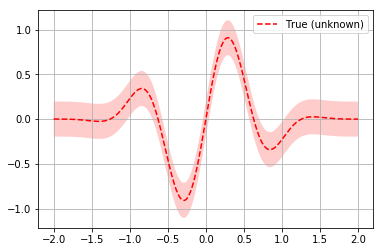

In [11]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()

Bayesian Optimization based on Gaussian Process regression is implemented in `skopt.gp_minimize` and can be carried out as follows:

In [13]:
res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f 
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=123)   # the random seed

Accordingly, the approximated minimum is found to be:

In [14]:
print "x^*=%.4f, f(x^*)=%.4f" % (res.x[0], res.fun)

x^*=-0.2939, f(x^*)=-0.9113


For further inspection of the results, attributes of the res named tuple provide the following information:

- `x [float]`: location of the minimum.
- `fun [float]`: function value at the minimum.
- `models`: surrogate models used for each iteration.
- `x_iters [array]`: location of function evaluation for each iteration.
- `func_vals [array]`: function value for each iteration.
- `space [Space]`: the optimization space.
- `specs [dict]`: parameters passed to the function.

In [23]:
print(res)

          fun: -0.80273097245820868
    func_vals: array([-0.58595405,  0.24648768,  0.11057704,  0.92336104, -0.3223665 ,
       -0.01593612, -0.38093039, -0.15015809, -0.04993988, -0.00714723,
        0.01772646, -0.02936562, -0.80273097, -0.79999509, -0.59693458])
       models: [GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
             kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
             n_restarts_optimizer=2, noise=0.01, normalize_y=True,
             optimizer='fmin_l_bfgs_b',
             random_state=<mtrand.RandomState object at 0x118d92690>), GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
             kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
             n_restarts_optimizer=2, noise=0.01, normalize_y=True,
             optimizer='fmin_l_bfgs_b',
             random_state=<mtrand.RandomState object at 0x10f9e0b90>), GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
             

Together these attributes can be used to visually inspect the results of the minimization, such as the convergence trace or the acquisition function at the last iteration:

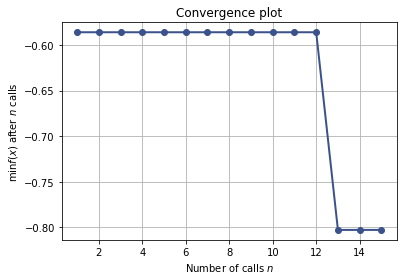

In [24]:
from skopt.plots import plot_convergence
plot_convergence(res);